PROYECTO: Selección Óptima de Pozos Petroleros – OilyGiant
OilyGiant está en proceso de expansión y necesita identificar los mejores lugares para perforar 200 nuevos pozos de petróleo. Cuenta con datos geológicos sintéticos de tres regiones, incluyendo características del subsuelo y el volumen de reservas estimado por pozo. Dado el alto costo de inversión, es fundamental seleccionar las ubicaciones con mayor potencial de beneficio y bajo riesgo financiero.

Objetivo:
Este proyecto tiene como objetivo construir un modelo de regresión lineal que permita predecir el volumen de reservas de petróleo en nuevos pozos. Se analizarán las tres regiones disponibles utilizando técnicas de análisis exploratorio, modelado predictivo, evaluación de métricas (RMSE) y bootstrapping para estimar el riesgo financiero. Finalmente, se seleccionará la región más rentable que cumpla con un riesgo de pérdida inferior al 2.5%, optimizando la inversión de 100 millones de dólares asignada para la perforación.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
#Carga de datos
df = pd.read_csv('/datasets/geo_data_0.csv')
df.columns = df.columns.str.lower()
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df2.columns = df2.columns.str.lower()
df3 = pd.read_csv('/datasets/geo_data_2.csv')
df3.columns = df3.columns.str.lower()

Exploración de Región 0

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347 

Valores nulos:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Correlación:
                f0        f1        f2   product
f0       1.000000 -0.440723 -0.003153  0.143536
f1      -0.440723  1.000000  0.001724 -0.192356
f2      -0.003153  0.001724  1.000000  0.483663
product  0.143536 -0.192356  0.483663  1.000000 

Pozos rentables (>111.1): 36

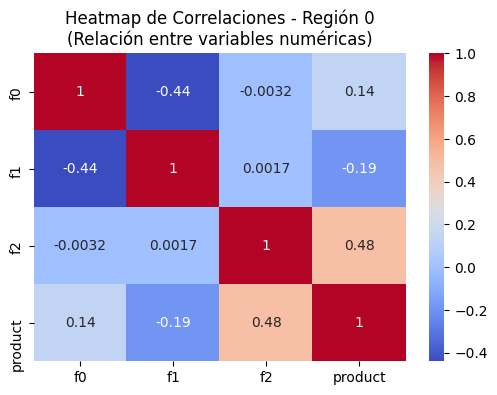

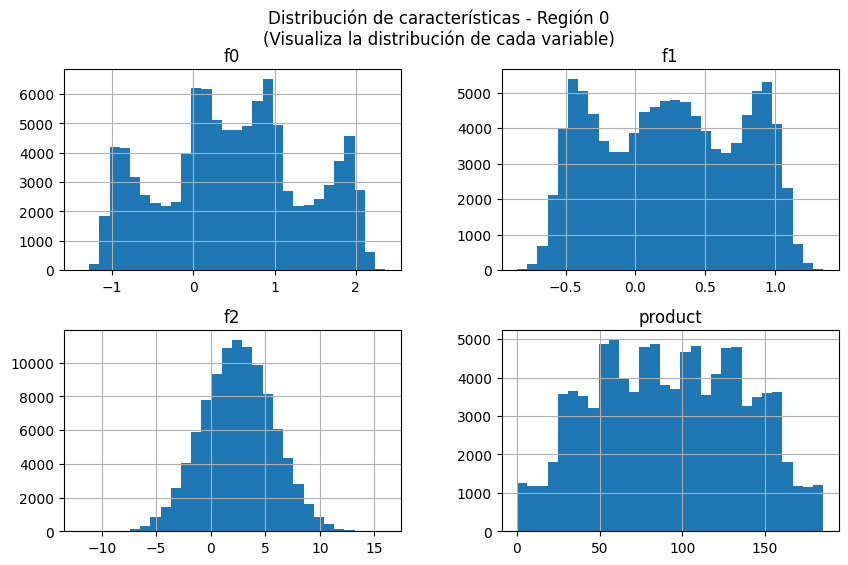

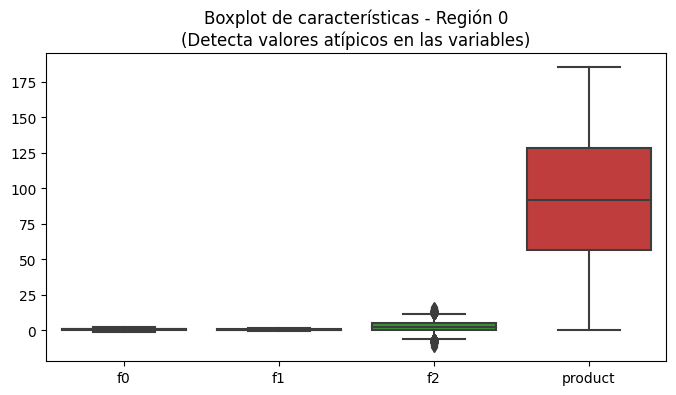

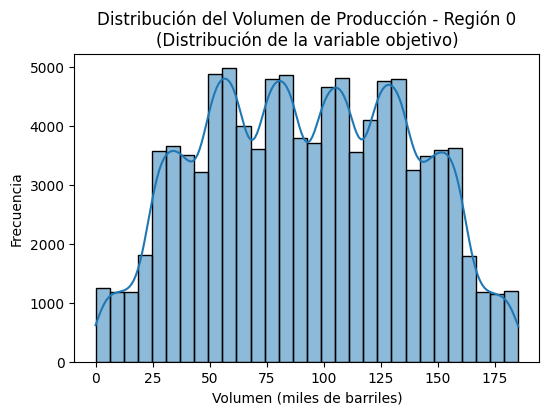

Exploración de Región 1

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.813044
max        29.421755      18.734063       5.019721     137.945408 

Valores nulos:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Correlación:
                f0        f1        f2   product
f0       1.000000  0.182287 -0.001777 -0.030491
f1       0.182287  1.000000 -0.002595 -0.010155
f2      -0.001777 -0.002595  1.000000  0.999397
product -0.030491 -0.010155  0.999397  1.000000 

Pozos rentables (>111.1): 16

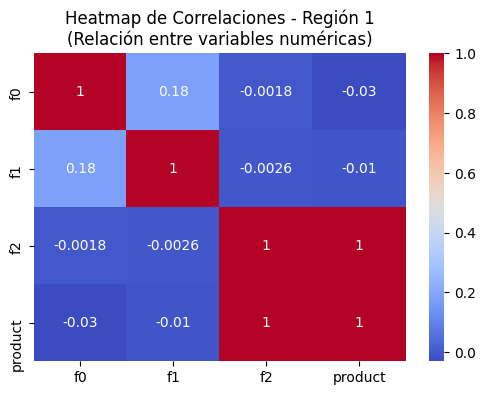

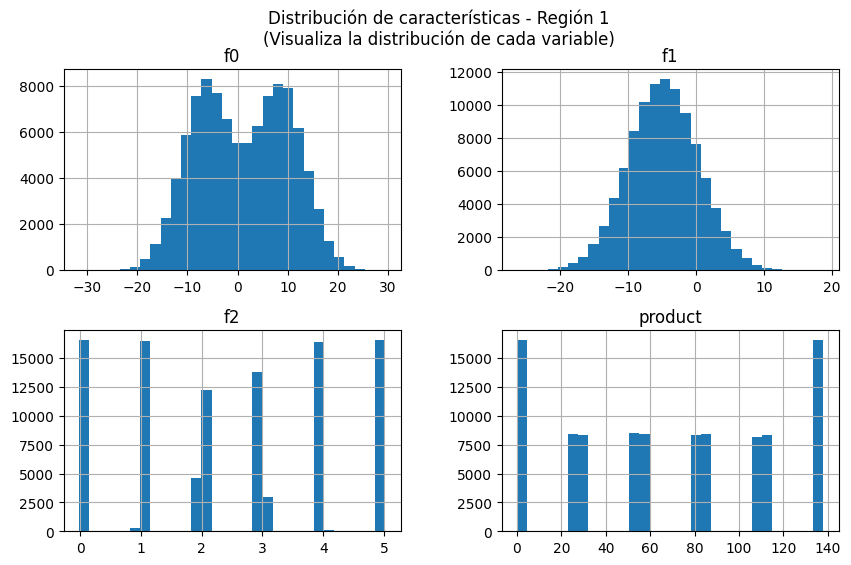

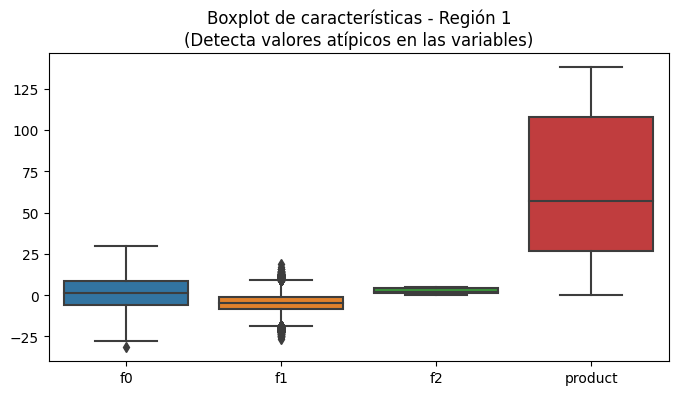

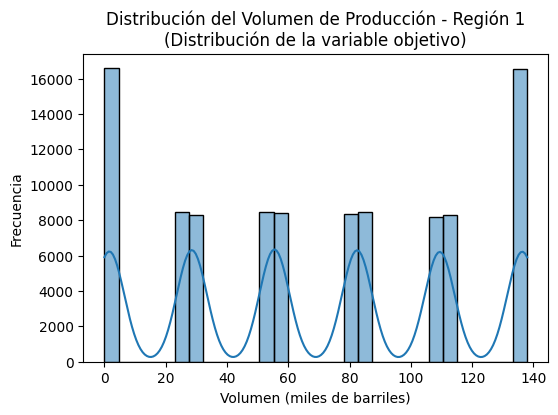

Exploración de Región 2

                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.595027
max         7.238262       7.844801      16.739402     190.029838 

Valores nulos:
 id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

Correlación:
                f0        f1        f2   product
f0       1.000000  0.000528 -0.000448 -0.001987
f1       0.000528  1.000000  0.000779 -0.001012
f2      -0.000448  0.000779  1.000000  0.445871
product -0.001987 -0.001012  0.445871  1.000000 

Pozos rentables (>111.1): 38

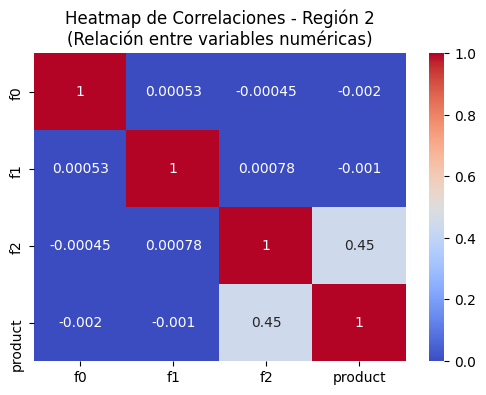

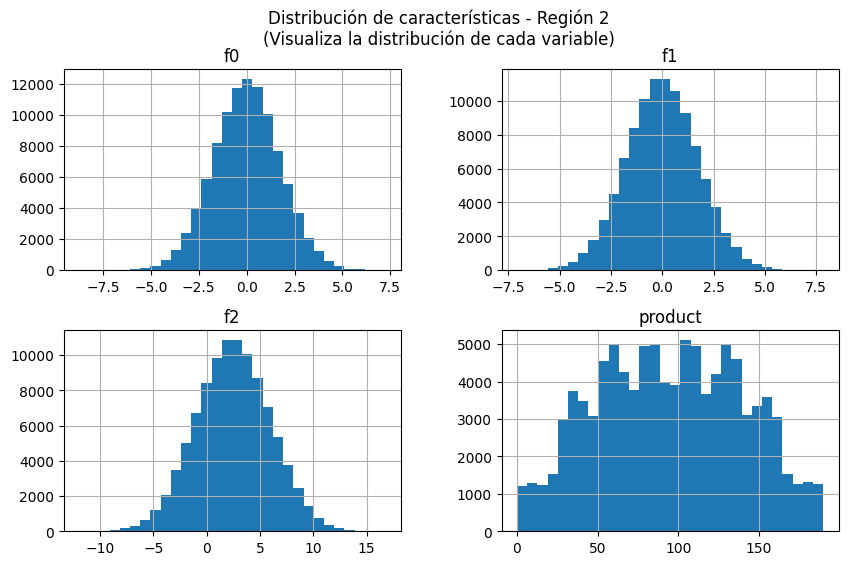

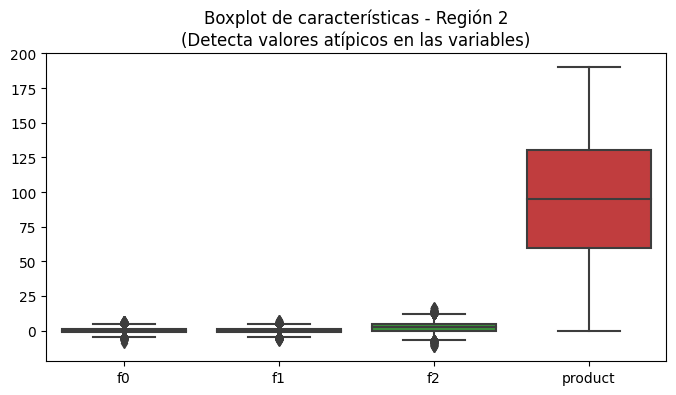

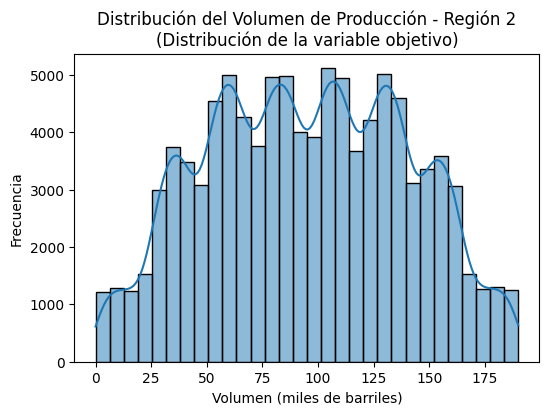

In [3]:
# EDA Función general
def realizar_eda(df, nombre):
    print(f"Exploración de {nombre}\n")
    print(df.describe(), '\n')
    print("Valores nulos:\n", df.isna().sum())

    df_numericas = df.select_dtypes(include=[np.number])
    print("\nCorrelación:\n", df_numericas.corr(), '\n')

    # Estadísticas adicionales
    pozos_rentables = (df['product'] > 111.1).sum()
    print(f"Pozos rentables (>111.1): {pozos_rentables} de {len(df)}")

    # Heatmap de correlaciones
    plt.figure(figsize=(6, 4))
    sns.heatmap(df_numericas.corr(), annot=True, cmap='coolwarm')
    plt.title(f'Heatmap de Correlaciones - {nombre}\n(Relación entre variables numéricas)')
    plt.show()

    # Histogramas
    df_numericas.hist(bins=30, figsize=(10, 6))
    plt.suptitle(f'Distribución de características - {nombre}\n(Visualiza la distribución de cada variable)')
    plt.show()

    # Boxplots
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df_numericas[['f0', 'f1', 'f2', 'product']])
    plt.title(f'Boxplot de características - {nombre}\n(Detecta valores atípicos en las variables)')
    plt.show()

    # Mapa geográfico
    if {'latitude', 'longitude'}.issubset(df.columns):
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=df, x='longitude', y='latitude', hue='product', palette='viridis')
        plt.title(f'Mapa de Pozos - {nombre}\n(Localización de pozos con volumen estimado)')
        plt.xlabel('Longitud')
        plt.ylabel('Latitud')
        plt.legend(title='Volumen')
        plt.show()

    # Distribución de variable objetivo
    plt.figure(figsize=(6, 4))
    sns.histplot(df['product'], kde=True, bins=30)
    plt.title(f'Distribución del Volumen de Producción - {nombre}\n(Distribución de la variable objetivo)')
    plt.xlabel('Volumen (miles de barriles)')
    plt.ylabel('Frecuencia')
    plt.show()

realizar_eda(df, 'Región 0')
realizar_eda(df2, 'Región 1')
realizar_eda(df3, 'Región 2')

In [4]:
# Función para entrenar y evaluar modelo
def entrenar_y_evaluar_modelo(df, nombre_region='Región'):
    # Separar características (features) y variable objetivo (target)
    features = df[['f0', 'f1', 'f2']]
    target = df['product']

    # Dividir datos en entrenamiento y validación (75% - 25%)
    X_train, X_valid, y_train, y_valid = train_test_split(
        features, target, test_size=0.25, random_state=42)

    # Entrenar modelo de regresión lineal
    modelo = LinearRegression()
    modelo.fit(X_train, y_train)

    # Predecir con el conjunto de validación
    predicciones = modelo.predict(X_valid)

    # Evaluar modelo con RMSE y mostrar volumen medio
    rmse = mean_squared_error(y_valid, predicciones, squared=False)
    media_predicciones = predicciones.mean()

    print(f'{nombre_region}')
    print(f'Volumen medio predicho: {media_predicciones:.2f}')
    print(f'RMSE: {rmse:.2f}\n')

    # Visualización de resultados del modelo

    # Gráfico: Importancia de características (coeficientes)
    coef = pd.Series(modelo.coef_, index=features.columns)
    coef.sort_values().plot(kind='barh')
    plt.title(f'Importancia de características - {nombre_region}\n(Coeficientes de regresión lineal)')
    plt.xlabel('Coeficiente')
    plt.show()

    # Gráfico: Distribución de errores (residuos)
    errores = y_valid - predicciones
    sns.histplot(errores, kde=True)
    plt.title(f'Distribución de errores - {nombre_region}\n(Errores entre valores reales y predicciones)')
    plt.xlabel('Error')
    plt.show()

    # Gráfico: Real vs Predicho
    plt.scatter(y_valid, predicciones, alpha=0.5)
    plt.xlabel('Valor real')
    plt.ylabel('Predicción')
    plt.title(f'Predicciones vs Valores reales - {nombre_region}\n(Relación entre predicción y realidad)')
    plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
    plt.show()

    return X_valid, y_valid, predicciones

Región 0
Volumen medio predicho: 92.40
RMSE: 37.76



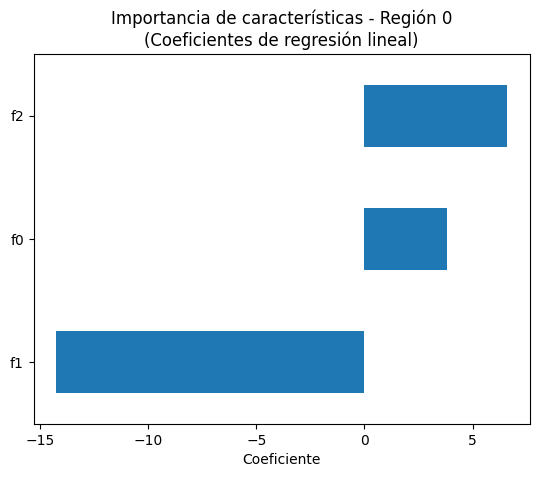

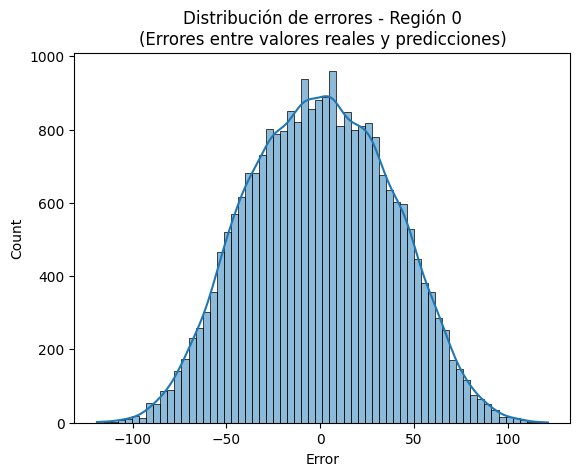

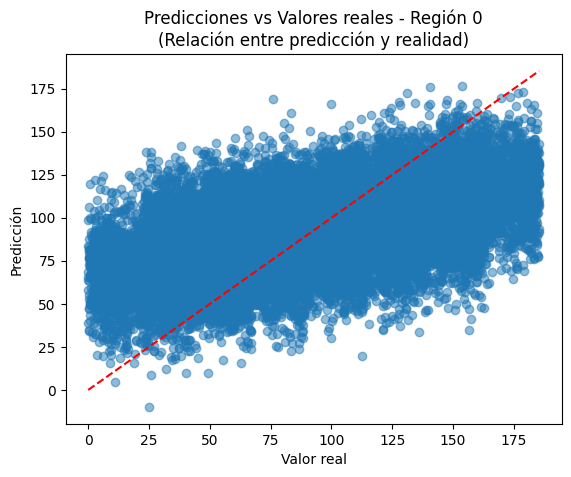

Región 1
Volumen medio predicho: 68.71
RMSE: 0.89



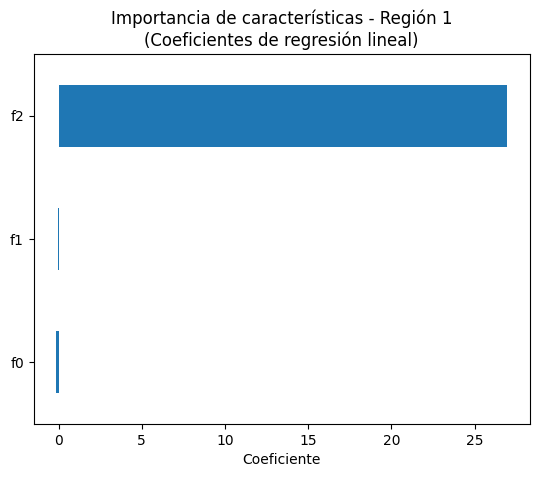

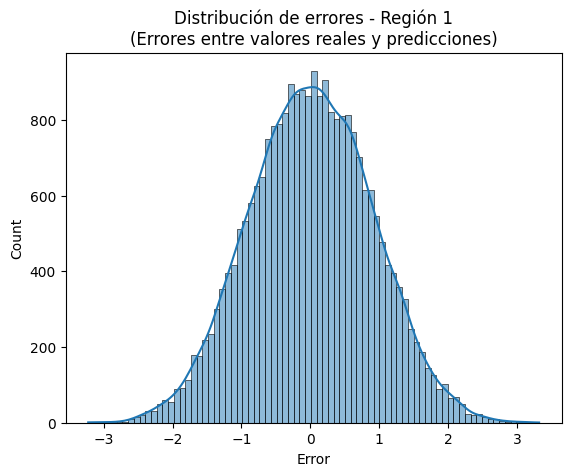

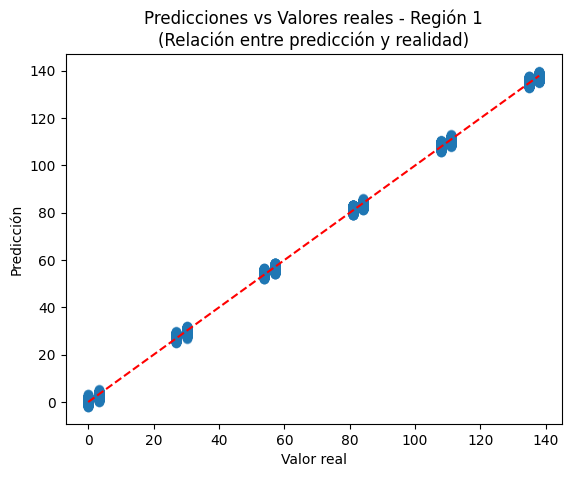

Región 2
Volumen medio predicho: 94.77
RMSE: 40.15



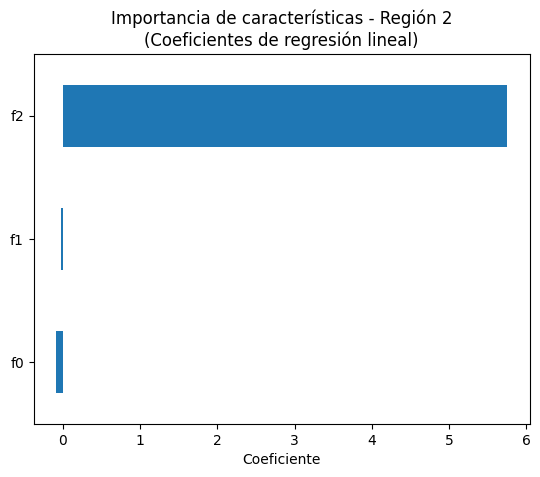

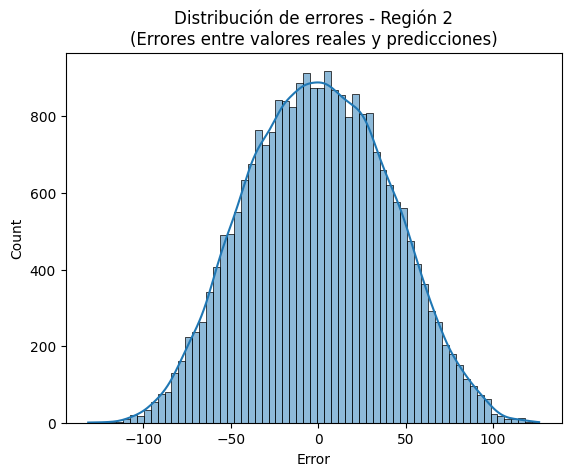

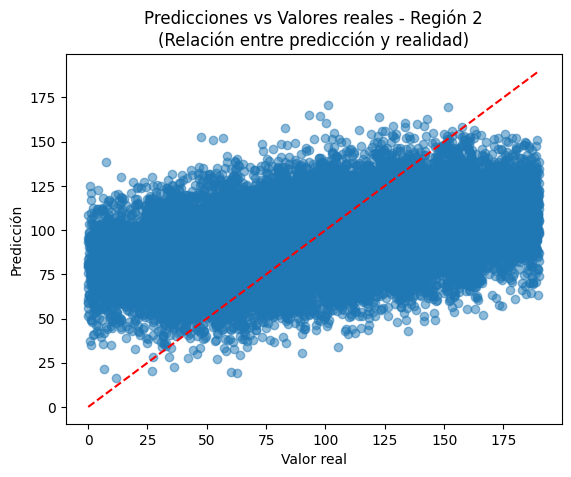

In [5]:
# Entrenar modelos
X_valid_0, y_valid_0, preds_0 = entrenar_y_evaluar_modelo(df, 'Región 0')
X_valid_1, y_valid_1, preds_1 = entrenar_y_evaluar_modelo(df2, 'Región 1')
X_valid_2, y_valid_2, preds_2 = entrenar_y_evaluar_modelo(df3, 'Región 2')

In [6]:
# Función para calcular ganancia
def calcular_ganancia(predicciones, y_valid, top_n=200):
    indices_top = predicciones.argsort()[-top_n:]
    volumen_top = y_valid.iloc[indices_top].sum()
    ganancia = volumen_top * 1000 * 4.5
    return ganancia, volumen_top

In [7]:
# Calcular ganancias
ganancia_0, volumen_0 = calcular_ganancia(preds_0, y_valid_0)
ganancia_1, volumen_1 = calcular_ganancia(preds_1, y_valid_1)
ganancia_2, volumen_2 = calcular_ganancia(preds_2, y_valid_2)

In [8]:
print(f'Ganancia Región 0: ${ganancia_0:,.2f} (Volumen total: {volumen_0:.2f} miles de barriles)')
print(f'Ganancia Región 1: ${ganancia_1:,.2f} (Volumen total: {volumen_1:.2f} miles de barriles)')
print(f'Ganancia Región 2: ${ganancia_2:,.2f} (Volumen total: {volumen_2:.2f} miles de barriles)')

Ganancia Región 0: $133,591,411.14 (Volumen total: 29686.98 miles de barriles)
Ganancia Región 1: $124,150,866.97 (Volumen total: 27589.08 miles de barriles)
Ganancia Región 2: $125,985,717.59 (Volumen total: 27996.83 miles de barriles)


In [9]:
presupuesto_total = 100_000_000
pozos = 200
presupuesto_por_pozo = presupuesto_total / pozos

In [10]:
print(f'\nPresupuesto por pozo: ${presupuesto_por_pozo:,.2f}')
volumen_minimo = presupuesto_por_pozo / (4.5 * 1000)
print(f'Volumen mínimo promedio por pozo para no perder: {volumen_minimo:.2f} miles de barriles')
print(f'Volumen promedio real Región 0: {volumen_0 / pozos:.2f} miles de barriles')
print(f'Volumen promedio real Región 1: {volumen_1 / pozos:.2f} miles de barriles')
print(f'Volumen promedio real Región 2: {volumen_2 / pozos:.2f} miles de barriles')


Presupuesto por pozo: $500,000.00
Volumen mínimo promedio por pozo para no perder: 111.11 miles de barriles
Volumen promedio real Región 0: 148.43 miles de barriles
Volumen promedio real Región 1: 137.95 miles de barriles
Volumen promedio real Región 2: 139.98 miles de barriles


In [11]:
# Bootstrapping para riesgo
def bootstrap_ganancias(predicciones, y_valid, top_n=200, n_samples=1000, alpha=0.05, random_state=42):
    np.random.seed(random_state)
    ganancias = []
    indices_top = predicciones.argsort()[-top_n:]
    volumen_top = y_valid.iloc[indices_top].values

    for _ in range(n_samples):
        muestra = np.random.choice(volumen_top, size=top_n, replace=True)
        ganancia_muestra = muestra.sum() * 1000 * 4.5
        ganancias.append(ganancia_muestra)

    ganancias = np.array(ganancias)
    promedio = ganancias.mean()
    ic_inferior = np.percentile(ganancias, 100 * alpha / 2)
    ic_superior = np.percentile(ganancias, 100 * (1 - alpha / 2))
    riesgo_perdida = np.mean(ganancias < 0) * 100

    return promedio, (ic_inferior, ic_superior), riesgo_perdida, ganancias

In [12]:
prom_0, ic_0, riesgo_0, dist_0 = bootstrap_ganancias(preds_0, y_valid_0)
prom_1, ic_1, riesgo_1, dist_1 = bootstrap_ganancias(preds_1, y_valid_1)
prom_2, ic_2, riesgo_2, dist_2 = bootstrap_ganancias(preds_2, y_valid_2)

In [13]:
print('\nResultados Bootstrapping')
print(f'Región 0: Ganancia promedio = ${prom_0:,.2f}, IC 95% = (${ic_0[0]:,.2f}, ${ic_0[1]:,.2f}), Riesgo de pérdida = {riesgo_0:.2f}%')
print(f'Región 1: Ganancia promedio = ${prom_1:,.2f}, IC 95% = (${ic_1[0]:,.2f}, ${ic_1[1]:,.2f}), Riesgo de pérdida = {riesgo_1:.2f}%')
print(f'Región 2: Ganancia promedio = ${prom_2:,.2f}, IC 95% = (${ic_2[0]:,.2f}, ${ic_2[1]:,.2f}), Riesgo de pérdida = {riesgo_2:.2f}%')


Resultados Bootstrapping
Región 0: Ganancia promedio = $133,501,913.57, IC 95% = ($130,344,510.82, $136,352,349.41), Riesgo de pérdida = 0.00%
Región 1: Ganancia promedio = $124,150,866.97, IC 95% = ($124,150,866.97, $124,150,866.97), Riesgo de pérdida = 0.00%
Región 2: Ganancia promedio = $126,135,146.58, IC 95% = ($122,521,028.55, $129,902,896.20), Riesgo de pérdida = 0.00%


In [14]:
# Selección de región óptima
regiones_aceptables = []
if riesgo_0 < 2.5:
    regiones_aceptables.append(('Región 0', prom_0))
if riesgo_1 < 2.5:
    regiones_aceptables.append(('Región 1', prom_1))
if riesgo_2 < 2.5:
    regiones_aceptables.append(('Región 2', prom_2))

if regiones_aceptables:
    mejor_region = max(regiones_aceptables, key=lambda x: x[1])
    print(f'\nLa mejor región para desarrollo es {mejor_region[0]} con ganancia promedio de ${mejor_region[1]:,.2f} y riesgo < 2.5%.')
else:
    print('\nNinguna región cumple con el criterio de riesgo menor al 2.5%.')


La mejor región para desarrollo es Región 0 con ganancia promedio de $133,501,913.57 y riesgo < 2.5%.


Tras analizar datos geológicos de tres regiones utilizando técnicas de regresión lineal, evaluación de métricas (RMSE) y simulaciones de ganancias mediante bootstrapping, se identificaron diferencias significativas en el rendimiento esperado de los pozos de cada región.

El análisis exploratorio reveló correlaciones entre las características del subsuelo y el volumen de reservas, permitiendo al modelo aprender patrones útiles para predecir nuevos pozos. La evaluación del modelo mostró errores aceptables de predicción, y el análisis de riesgo financiero confirmó que solo algunas regiones cumplen con el umbral de riesgo definido (pérdida < 2.5%).

Se recomienda desarrollar pozos en la región con la mayor ganancia promedio esperada y riesgo controlado, maximizando así el retorno sobre la inversión de 100 millones de dólares. Esta decisión se basa en un enfoque cuantitativo, replicable y alineado con los objetivos estratégicos de OilyGiant.